In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed=20

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
			  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
			  layers.RandomBrightness((-0.1,0.1),value_range=(0, 0.2)),
        tf.keras.layers.GaussianNoise(0.1, seed=20)

    ]
)

# Load some data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = x_train.shape[1:]
y_trainRandomised=y_train.copy()
np.random.shuffle(y_trainRandomised)
classes = 10


from sklearn.model_selection import train_test_split
#zebysmy nie uczyli na tescie

x_t, x_val, y_t, y_val = train_test_split(x_train, y_trainRandomised, test_size=0.2, random_state=20)

# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((x_t, y_t))
train_dataset = train_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))#bylo16

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))


# Create a model and train it on the augmented image data
inputs = keras.Input(shape=input_shape)
x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale inputs
output = keras.applications.ResNet50(  # Add the rest of the model
    weights=None, input_shape=input_shape, classes=classes, include_top=False
)(x)
outputs = keras.layers.Dense(10, activation='softmax')(output)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])#rmsprop

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 1, 1, 10)          20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [3]:
y_trainRandomised.shape

(50000, 1)

In [4]:
print(y_train[0:5])
print(y_trainRandomised[0:5])

[[6]
 [9]
 [9]
 [4]
 [1]]
[[2]
 [0]
 [5]
 [9]
 [4]]


Epoch 1/3
313/313 [==============================] - 2812s 9s/step - loss: 2.5719 - accuracy: 0.1002 - val_loss: 2.3563 - val_accuracy: 0.1015
Epoch 2/3
313/313 [==============================] - 2813s 9s/step - loss: 2.4934 - accuracy: 0.0989 - val_loss: 2.3110 - val_accuracy: 0.1013
Epoch 3/3
313/313 [==============================] - 2818s 9s/step - loss: 2.5393 - accuracy: 0.1007 - val_loss: 2.3149 - val_accuracy: 0.1004


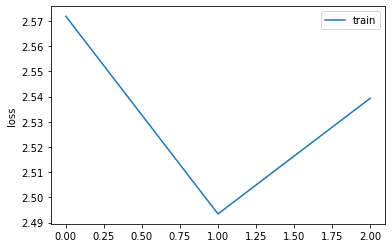

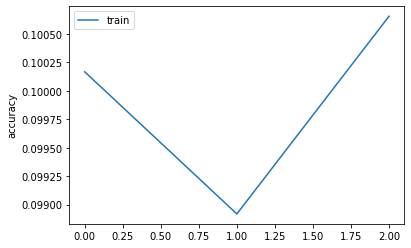

In [ ]:
history_resnetOn = model.fit(train_dataset,validation_data=validation_dataset,epochs=3,batch_size=512) #, tego nie chcemy chyba, bedzie sie duzo dluzej trenowal jak by co, bo bedzie 2500 krokow zamiast 5

plt.plot(history_resnetOn.history['loss'], label='train')
# plt.plot(history_resnetOn.history['val_loss'], label='val')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history_resnetOn.history['accuracy'], label='train')
# plt.plot(history_resnetOn.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
print(history_resnetOn.history)

{'loss': [2.5719010829925537, 2.493429183959961, 2.5393288135528564], 'accuracy': [0.10016783326864243, 0.09891780465841293, 0.10065611451864243], 'val_loss': [2.356269598007202, 2.3109729290008545, 2.314924716949463], 'val_accuracy': [0.1014537513256073, 0.10128163546323776, 0.10035847127437592]}


In [ ]:
#model.save('localstorage://my-model')

In [ ]:
# Create a model and train it on the augmented image data



#model = tf.keras.models.load_model('saved_model/my_model')

modelResnetStatic=keras.Sequential([
    model.get_layer(name="input_1"),
    model.get_layer(index=1),
    model.get_layer(index=2),
    layers.Dense(10, activation='softmax', kernel_initializer='he_uniform'),

    
    #(trainable# bez ostatniej warsty, train = off, zaimportowane wagi


])
modelResnetStatic.build((None,32,32,3))
modelResnetStatic.layers[1].set_weights(model.layers[2].get_weights())  

modelResnetStatic.layers[0].trainable = False
modelResnetStatic.layers[1].trainable = False
modelResnetStatic.layers[2].trainable = True


modelResnetStatic.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelResnetStatic.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense_1 (Dense)             (None, 1, 1, 10)          20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#Test if model weights are not reset
print(model.layers[1].get_config(),model.layers[1].get_weights())
print(modelResnetStatic.layers[0].get_config(),model.layers[0].get_weights())
#jest takie samo

{'name': 'rescaling', 'trainable': False, 'dtype': 'float32', 'scale': 0.00392156862745098, 'offset': 0.0} []
{'name': 'rescaling', 'trainable': False, 'dtype': 'float32', 'scale': 0.00392156862745098, 'offset': 0.0} []


In [ ]:
print(model.layers[1].get_config()==modelResnetStatic.layers[0].get_config())
#to ma byc true

True


In [ ]:
#print(model.layers[1].get_weights()==modelResnetStatic.layers[0].get_weights())

#to ma byc true

In [ ]:
#print((model.layers[2].get_weights()==modelResnetStatic.layers[1].get_weights()).all())

#cos sie nie zgadza?

In [ ]:
print(model.layers[2].get_config(),model.layers[2].get_weights())


Streaming output truncated to the last 5000 lines.
        10.15481  ,   8.195532 ,   8.125034 ,  29.289747 ,  10.905001 ,
        16.520998 ,  13.222528 ,   8.277058 ,   8.833931 ,  15.094714 ,
         7.723468 ,   8.822973 ,  63.355465 , 104.40181  , 173.87012  ,
        32.46143  ,   9.931991 ,   5.5998893,   7.133306 ,   6.1116505,
         7.4861045,   7.8654103,   8.814934 ,  13.989176 ,   8.871444 ,
        13.907845 ,  28.277983 ,  31.392847 ,  17.614742 ,   6.4500957,
        12.270924 ,   9.25101  ,  12.6059065,   8.413398 ,  82.45208  ,
        11.6911955,  14.4009075,  11.550402 ,   6.531492 ,  10.686372 ,
        87.82498  ,  71.04966  ,  39.631687 , 119.32817  ,  72.65096  ,
         6.4478226,  10.895102 ,   9.66596  ,  91.71788  ,  30.196188 ,
         7.5887413,  17.741325 ,  19.216143 ,  77.54217  ,   5.288633 ,
        15.338861 ,   6.443013 ,  16.115208 ,   5.9092298,  32.83696  ,
         3.63845  ,  17.569292 ,  11.440249 ,  50.36518  ,  26.168983 ,
        78.92

In [ ]:

print(modelResnetStatic.layers[1].get_weights())

[array([[[[-2.15719994e-02,  2.11394019e-02, -1.15427980e-02, ...,
           1.13934381e-02, -1.33005790e-02,  2.47485787e-02],
         [ 2.45973598e-02,  4.76059802e-02, -4.59081493e-02, ...,
           6.00579241e-03, -2.76686829e-02, -3.82373370e-02],
         [-1.00862710e-02,  4.18509580e-02, -2.09959340e-03, ...,
           3.40323523e-02,  1.47484837e-03, -3.91628258e-02]],

        [[ 1.09506620e-03,  2.07954589e-02, -4.06161770e-02, ...,
          -1.34107396e-02, -7.86460657e-03, -3.12654395e-03],
         [-2.71127298e-02, -1.17551107e-02,  2.45873425e-02, ...,
          -3.06836385e-02,  1.25000940e-03,  2.87701078e-02],
         [-2.82490589e-02, -7.87065271e-03,  3.15877609e-03, ...,
          -3.95033334e-04, -3.77795957e-02, -1.58486944e-02]],

        [[ 7.19983131e-02,  4.01971824e-02,  1.20547786e-02, ...,
           3.46396081e-02,  1.34872310e-02, -1.67233720e-02],
         [ 6.40278235e-02,  2.53560138e-05, -4.02567275e-02, ...,
          -2.15458386e-02,  1.157

In [ ]:
#eksperymentalnie zrobmy przepięcie wskaznikow
# modelResnetStatic.layers[1]=model.layers[2]
# print(model.layers[2].get_weights()==modelResnetStatic.layers[1].get_weights())


In [ ]:
x_t, x_val, y_t, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)


# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((x_t, y_t))
train_dataset = train_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))#bylo16

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))

In [ ]:
history_resnetOff = modelResnetStatic.fit(train_dataset,validation_data=validation_dataset, epochs=3,batch_size=512) #steps_per_epoch=3 tego nie chcemy chyba, bedzie sie duzo dluzej trenowal jak by co, bo bedzie 2500 krokow zamiast 5

plt.plot(history_resnetOff.history['loss'], label='train')
plt.plot(history_resnetOff.history['val_loss'], label='val')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history_resnetOff.history['accuracy'], label='train')
plt.plot(history_resnetOff.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
modelResnetStatic.evaluate(x_test,y_test)